# Taylor integration of the Kepler problem

Here, we try to reproduce __exactly__ the [Kepler problem integration](http://nbviewer.jupyter.org/github/JuliaDiff/TaylorSeries.jl/blob/master/examples/1-KeplerProblem.ipynb) made by Luis Benet using [JuliaDiff/TaylorSeries.jl](https://github.com/JuliaDiff/TaylorSeries.jl).

In cartesian coordinates over the orbital plane, the Hamiltonian for the Kepler problem reads:

$$
H_{\mathrm{Kepler}}=\frac{1}{2\mu}(p_x^2+p_y^2)-\frac{\mu}{\sqrt{x^2+y^2}}
$$

where $\mu=G(m_1+m_2)$, $G$ is the gravitational constant, $m_1$ is the mass of the primary body and $m_2$ is the mass of the secondary body. Using Hamilton equations, we obtain the equations of motion for the Kepler problem:

$$
\begin{align}
\dot x &= u \\
\dot y &= v \\
\dot u &= -\frac{\mu x}{(x^2+y^2)^{3/2}}\\
\dot v &= -\frac{\mu y}{(x^2+y^2)^{3/2}}\\
\\
\end{align}
$$


We start by including all relevant packages:

In [1]:
using TaylorIntegration #our numerical integrator
using PyPlot #to draw some plots
using FastAnonymous #to gain some performance in julia 0.4.x

Some parameters necessary for the integration:

+ $\mu$: the gravitational parameter
+ `q0`: the initial state
+ `order`: the order of the Taylor expansion
+ `t_max`: the final time of the integration
+ `abs_tol`: the absolute tolerance
+ `n_iter`: the number of time-steps

In [59]:
const μ = 1.0
const q0 = [0.19999999999999996, 0.0, 0.0, 3.0] # initial condition
const order = 28
const t0 = 0.0
const tmax = 10000*(2π) # we are just taking a wild guess about the period ;)
const abstol = 1.0E-20
const iterations = typemax(Int64)

9223372036854775807

As usual, we write down the equations of motion in a `function`. `q` represents the system state, with the first component being the current value of the independent variable. Hence, its evolution is given by $\dot t = 1$. `params` represents the parameters of a given system of differential equations. In the Kepler problem case, the only parameter is $\mu$, the mass parameter.

In [60]:
function kepler_problem(t, x)
    r_p3d2 = (x[1]^2+x[2]^2)^(3/2)
    
    return [x[3], x[4], -μ*x[1]/r_p3d2, -μ*x[2]/r_p3d2]
end

kepler_problem (generic function with 1 method)

`FastAnonymous` versions of `kepler_problem` and `stepsizeall_anon`:

In [61]:
kepler_anon = @anon (t__, q__) -> kepler_problem(t__, q__)

(t__,q__) -> quote  # In[61], line 1:
    Main.kepler_problem(t__,q__)
end

The Taylor integration:

In [62]:
?taylorinteg

search: taylorinteg TaylorIntegration



```
taylorinteg(f, x0, t0, tmax, order, abs_tol; keyword... )
```

This is a general-purpose Taylor integrator for the explicit ODE $\dot{x}=f(x)$ with initial condition specified by `x0` at time `t0`. It returns a vector with the values of time (independent variable), and a vector (of of type `typeof(x0)`) with the computed values of the dependent variables. The integration stops when time is larger than `tmax`, or the number of saved steps is larger than `maxsteps`.

The integrator uses polynomial expansions on the independent variable of order `order` and the parameter `abs_tol` serves to define the time step using the last two Taylor coefficients of the expansions.

The current keyword arguments is `maxsteps=500`.


In [86]:
q0

4-element Array{Float64,1}:
 0.2
 0.0
 0.0
 3.0

In [87]:
@time t, q = taylorinteg(kepler_anon, q0, t0, tmax, order, abstol, maxsteps=iterations);

 46.726886 seconds (461.89 M allocations: 36.779 GB, 22.73% gc time)


The final state:

In [88]:
t[end], q[end]

(62831.85650193086,[0.19985298833903653,0.010287886829271349,-0.08568200522828756,2.9977961210694137])

Extract state variable vectors $x$, $y$, $u$, $v$ from `taylorinteg` output, which was stored in `q`:

In [89]:
myindex=1;
for var = (:x, :y, :u, :v)
    @eval $var = map(q -> q[$myindex], $q)
    myindex+=1
end

Just making sure we did things right:

In [90]:
t[end], x[end], y[end], u[end], v[end]

(62831.85650193086,0.19985298833903653,0.010287886829271349,-0.08568200522828756,2.9977961210694137)

The number of time steps is equal to the `length` of vector `t` minus 1:

In [91]:
length(t)-1

436152

A `FastAnonymous` version of the Hamiltonian:

In [92]:
H = @anon (x__, y__, u__, v__) -> 0.5*(u__*u__+v__*v__)-μ/sqrt(x__*x__+y__*y__)

(x__,y__,u__,v__) -> quote  # In[92], line 1:
    Main.-(Main.*(0.5,Main.+(Main.*(u__,u__),Main.*(v__,v__))),Main./(μ,Main.sqrt(Main.+(Main.*(x__,x__),Main.*(y__,y__)))))
end
with:
  μ: 1.0

The energy during each time-step:

In [93]:
E = map(H, x, y, u, v);

The initial energy:

In [94]:
E0=E[1]

-0.5000000000000009

The relative error in the energy is $\delta E$:

In [95]:
δE = (E-E0)/(E0);

A $\delta E$ vs $t$ plot:

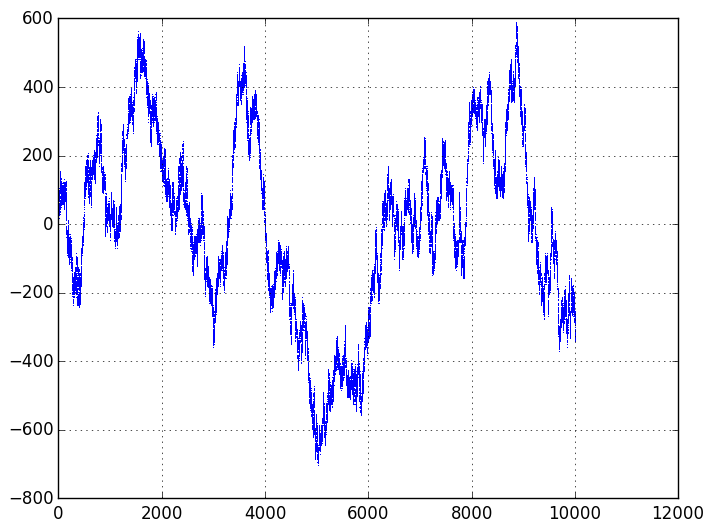

In [96]:
grid(true)
plot(t/(2π), δE/eps(Float64), ",");

How does the energy error distribute around zero?

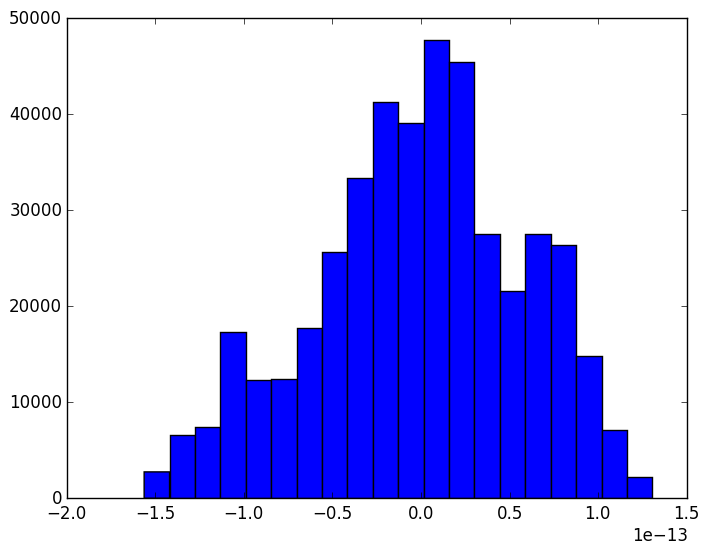

In [97]:
h = plt[:hist](δE, 20);

A `FastAnonymous` version of the angular momentum:

In [98]:
L_anon = @anon (x_, y_, u_, v_) -> x_*v_-y_*u_

(x_,y_,u_,v_) -> quote  # In[98], line 1:
    Main.-(Main.*(x_,v_),Main.*(y_,u_))
end

The angular momentum during each time-step:

In [99]:
L = map(L_anon, x, y, u, v);

The initial angular momentum:

In [100]:
L0 = L[1]

0.5999999999999999

The relative error in the angular momentum during the integration is $\delta L$:

In [101]:
δL = (L-L0)/L0;

A $\delta L$ vs $t$ plot:

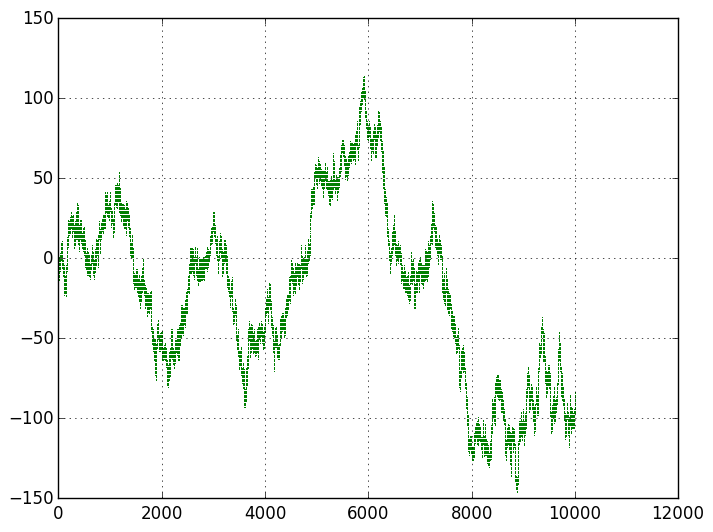

In [102]:
grid(true)
plot(t/(2π), δL/eps(Float64), "g,");

What is the distribution of the angular momentum relative error?

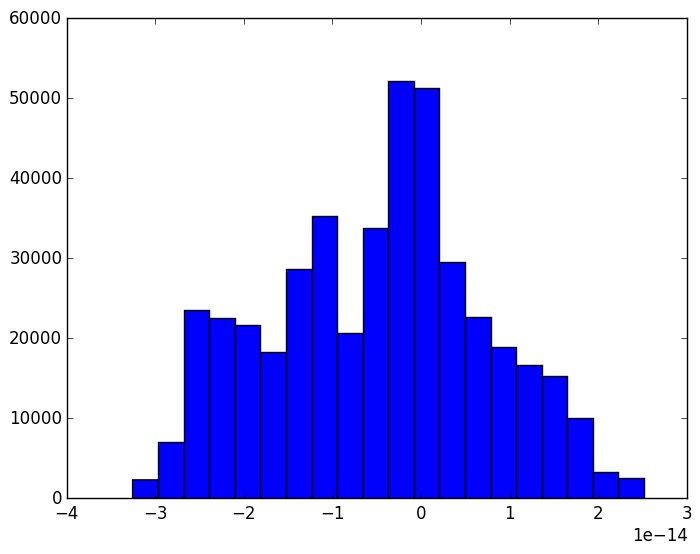

In [103]:
h = plt[:hist]( δL, 20 );

A $\delta E$, $\delta L$ plot vs $t$:

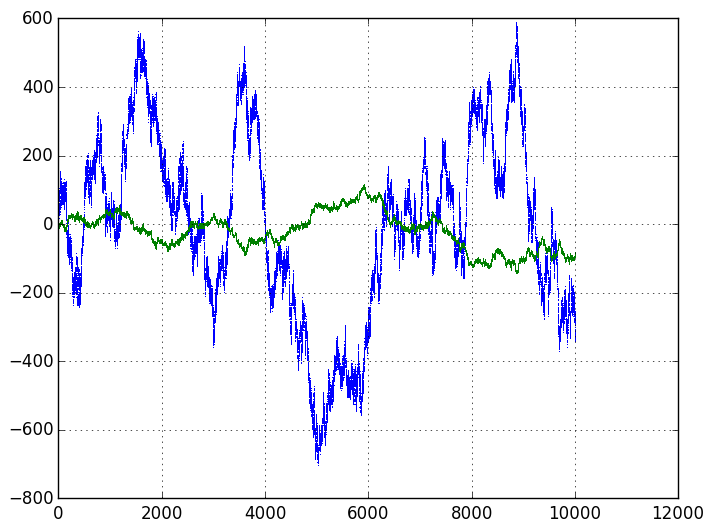

In [104]:
grid(true)
plot(t/(2π), δE/eps(Float64), "b,", t/(2π), δL/eps(Float64), "g,");